In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pyloess.Loess import Loess
from scipy import interpolate
import pickle
%matplotlib inline

In [2]:
def load_poll_data(reload=True):
    if not reload:
        with open('pickles/df_polls.p', 'rb') as f:
            df_polls = pickle.load(f)
        return df_polls
    
    resp = requests.get("https://en.wikipedia.org/wiki/Opinion_polling_for_the_2020_New_Zealand_general_election")
    soup = bs(resp.text)
    table = soup.findAll("table", {"class" : "sortable"})[0]
    colnames = []
    for th in table.findAll("th"):
        colnames.append(th.text)
    colnames[0] = "Date"
    colnames = [i.strip() for i in colnames]
    data = [[], [], [], [], [], [], [], [], [], [], [], [], []]

    for tr in table.findAll("tr"):
        tds = tr.findAll("td")
        if len(tds) == 13:
            for i in range(len(tds)):
                text = tds[i].text.strip()
                text = text.split('[')[0]
                cell = None

                if i == 0:
                    cell = text.split('–')[-1].strip()

                    try:
                        cell = datetime.strptime(cell, '%d %b %Y').date()
                    except ValueError:
                        cell = '15 ' + cell
                        cell = datetime.strptime(cell, '%d %b %Y').date()

                elif i == 2:
                    cell = ('').join(text.split(','))
                    try:
                        cell = int(cell)
                    except ValueError:
                        cell = np.nan 
                elif i > 1:
                    try:
                        cell = float(text)
                    except ValueError:
                        cell = np.nan
                else:
                    cell = text

                if i == len(tds)-1 and cell == np.nan:
                    cell = 0.0

                assert cell != None

                data[i].append(cell)

    colnames = colnames[:13]
    df_polls = pd.DataFrame(np.array(data).transpose(), columns=colnames)
    df_polls.sort_values(by='Date', inplace=True)
    df_polls.reset_index(drop=True, inplace=True)
        
    epoch = min(df_polls['Date'])
    df_polls['Date_float'] = df_polls['Date'].apply(lambda x : (x - epoch).total_seconds())
    
    with open('pickles/df_polls.p', 'wb') as f:
        pickle.dump(df_polls, f)
    
    return df_polls

In [3]:
def extrap_poll_data(df_polls, n=30, window=15, degree=1, recalculate=True, reload_results=True):
    if not recalculate and not reload_results:
        with open('pickles/df_extrap.p', 'rb') as f:
            df_extrap = pickle.load(f)
        return df_extrap
    
    name_long = ['National', 'Labour', 'NZ First', 'Greens', 'ACT', 'TOP', 'Maori', 'New Conservatives', 'Advance NZ']
    colour = ['#035d96', '#d82c20','black', '#00ba31', 'yellow', '#09b598', '#da0017', '#207CCA', 'blue']
    
    percent_2017 = [44.45, 36.89, 7.20, 6.27, 0.50, 2.44, 1.18, 0.24, 0]
    seats_2017 = [56, 46, 9, 8, 1, 0, 0, 0, 0]
    
    names = ['LAB', 'NAT', 'ACT', 'GRN', 'MRI', 'NZF', 'NCP', 'TOP']
    
    if reload_results:
        resp = requests.get("https://www.electionresults.govt.nz/")
        soup = bs(resp.text)

        
        actual_percent = []
        actual_seats = []
        for th in soup.find("table").findAll("tr"):
            tds = th.findAll("td")
            if len(tds) == 6:
                if len(actual_percent) >= 8:
                    break
                actual_percent.append(float(tds[2].text))

                try:
                    actual_seats.append(int(tds[-1].text))
                except ValueError:
                    actual_seats.append(0)

        assert len(actual_percent) == 8
        assert len(actual_seats) == 8

        with open('pickles/actual_percent.p', 'wb') as f:
            pickle.dump(actual_percent, f)

        with open('pickles/actual_seats.p', 'wb') as f:
            pickle.dump(actual_seats, f)
    
    else:
        with open('pickles/actual_percent.p', 'rb') as f:
            actual_percent = pickle.load(f)

        with open('pickles/actual_seats.p', 'rb') as f:
            actual_seats = pickle.load(f)
    
    row_list = []
    
    for i, name_short in enumerate(df_polls.columns[3:-3]):
        party_dict = {}
        
        party_dict['name_short'] = name_short
        party_dict['name_long'] = name_long[i]
        party_dict['colour'] = colour[i]
        
        party_dict['percent_2017'] = percent_2017[i]
        party_dict['seats_2017'] = seats_2017[i]
        
        try:
            index = names.index(name_short)
            party_dict['actual_percent'] = actual_percent[index]
            party_dict['actual_seats'] = actual_seats[index]
        except ValueError:
            party_dict['actual_percent'] = 0
            party_dict['actual_seats'] = 0
        
        x = df_polls['Date_float'][df_polls[name_short].notnull()].values
        y = df_polls[name_short][df_polls[name_short].notnull()].values

        loess = Loess(x, y)
        
        epoch = min(df_polls['Date'][df_polls[name_short].notnull()])
    
        epoch_float = min(df_polls['Date_float'][df_polls[name_short].notnull()])

        election_day = datetime(2020, 10, 17).date()

        xx = np.linspace(epoch_float, (election_day - epoch).total_seconds(), n)

        xx_date = np.array([datetime.fromtimestamp(i+epoch_float) for i in xx])
        
        yy = np.array([loess.estimate(xx[i], window=window, degree=degree) for i in range(len(xx))])
        
        for i in range(len(xx_date)):
            party_dict[xx[i]] = yy[i]
            
        row_list.append(party_dict)

    df_extrap = pd.DataFrame(row_list)

    df_extrap['pred_percent'] = df_extrap[df_extrap.columns[-1]]
    df_extrap['error'] = df_extrap['actual_percent'] - df_extrap['pred_percent']

    # SEATS
    df_extrap['effective_percent'] = df_extrap[df_extrap.columns[-1]].apply(lambda x : x if x >= 5 else 0)
    df_extrap['effective_percent'] = df_extrap['effective_percent'] / np.sum(df_extrap['effective_percent']) * 100

    with open('pickles/df_extrap.p', 'wb') as f:
        pickle.dump(df_extrap, f)
        
    df_extrap.sort_values(by='pred_percent', ascending=False, inplace=True)

    return df_extrap

In [4]:
df_polls = load_poll_data(reload=False)

n = 5
window = 24
degree = 1

df_extrap = extrap_poll_data(df_polls, n=n, window=window, degree=degree, recalculate=False, reload_results=False)
df_extrap[['name_long','pred_percent','actual_percent','error']]

,name_long,pred_percent,actual_percent,error
0,National,29.313883,26.8,2.513883
1,Labour,49.152468,49.1,0.052468
2,NZ First,2.214078,2.7,-0.485922
3,Green,7.047607,7.6,-0.552393
4,ACT,7.539207,8.0,-0.460793
5,TOP,1.121113,1.4,-0.278887
6,Maori,0.766895,1.0,-0.233105
7,New Conservatives,1.439576,1.5,-0.060424


In [5]:
xticks = []
xticks_format = []
for year in [2018, 2019, 2020]:
    for month in [1, 5, 9]:
        date = datetime(year, month, 1)
        xticks.append(date)
        xticks_format.append(date.strftime("%b %y"))
        
yticks_all = np.arange(0, 70, 10)
yticks_all_format = [str(i)+'%' for i in yticks_all]

today_str = datetime.today().strftime("%Y-%b-%d")
election_day = datetime(2020, 10, 17).date()

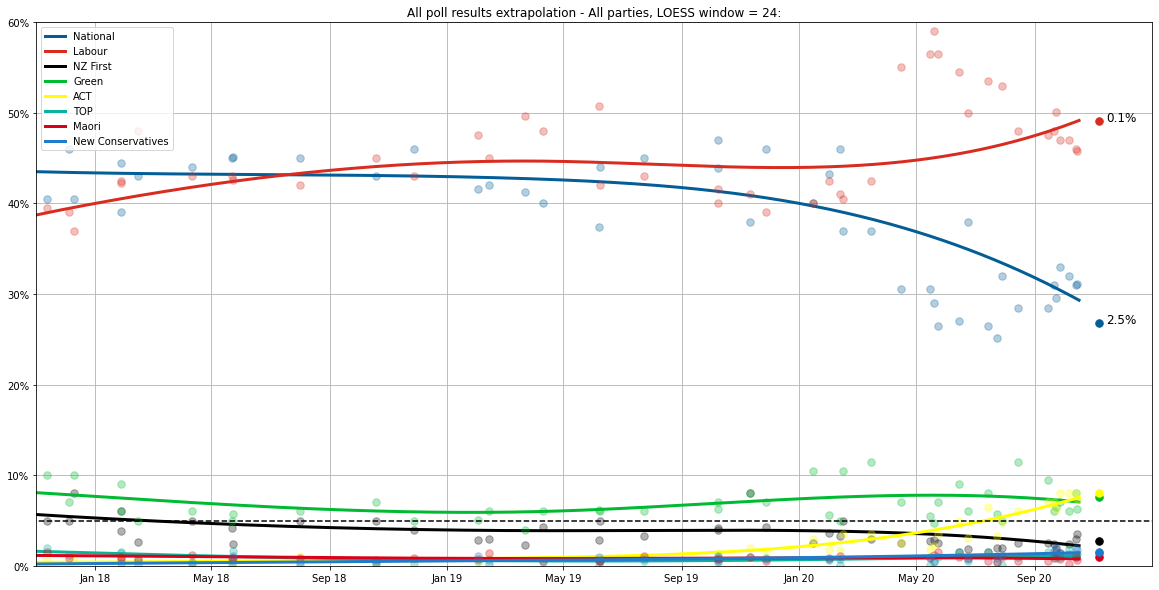

In [6]:
# ALL PARTIES
plt.figure(figsize=(20, 10))

for index, row in df_extrap.iterrows():
    
    party = row['name_short']
    
    plt.plot(df_polls['Date'], df_polls[party],
             color=row['colour'], linestyle='None', marker='.', markersize=15, alpha=0.3)
    
    x = row[7:7+n].index
    y = row[7:7+n].values
    
    epoch = min(df_polls['Date'][df_polls[party].notnull()])
    
    epoch_float = datetime.timestamp(datetime.combine(epoch, datetime.min.time()))
    
    xx = np.linspace(min(x), (election_day - epoch).total_seconds(), 1000)

    p = interpolate.splrep(x, y)
    yy = interpolate.splev(xx, p)
    
    xx_date = np.array([datetime.fromtimestamp(i+epoch_float) for i in xx])

    plt.plot(xx_date, yy, linestyle='-', color=row['colour'], linewidth=3, label=row['name_long'])

    if yy[-1] >= 10:
        plt.annotate(f'{row["error"]:.1f}%', (election_day+timedelta(days=28), row['actual_percent']), size=12)
        
    plt.plot(election_day+timedelta(days=21), row['actual_percent'], color=row['colour'], linestyle='None', marker='.', markersize=15)

plt.plot(xx, np.full(len(xx), 5.), 'k--', linewidth=1.5)
plt.grid(True)
plt.xlim(datetime(2017, 11, 1), datetime(2021, 1, 1))
plt.xticks(xticks, xticks_format)
plt.ylim(min(yticks_all), max(yticks_all))
plt.yticks(yticks_all, yticks_all_format)
plt.legend(loc=2)
plt.title(f'All poll results extrapolation - All parties, LOESS window = {window}:');
# plt.savefig(f'{today_str}_poll_all_parties_lowess_{window}.jpg', dpi=150, format='jpg', bbox_inches='tight');

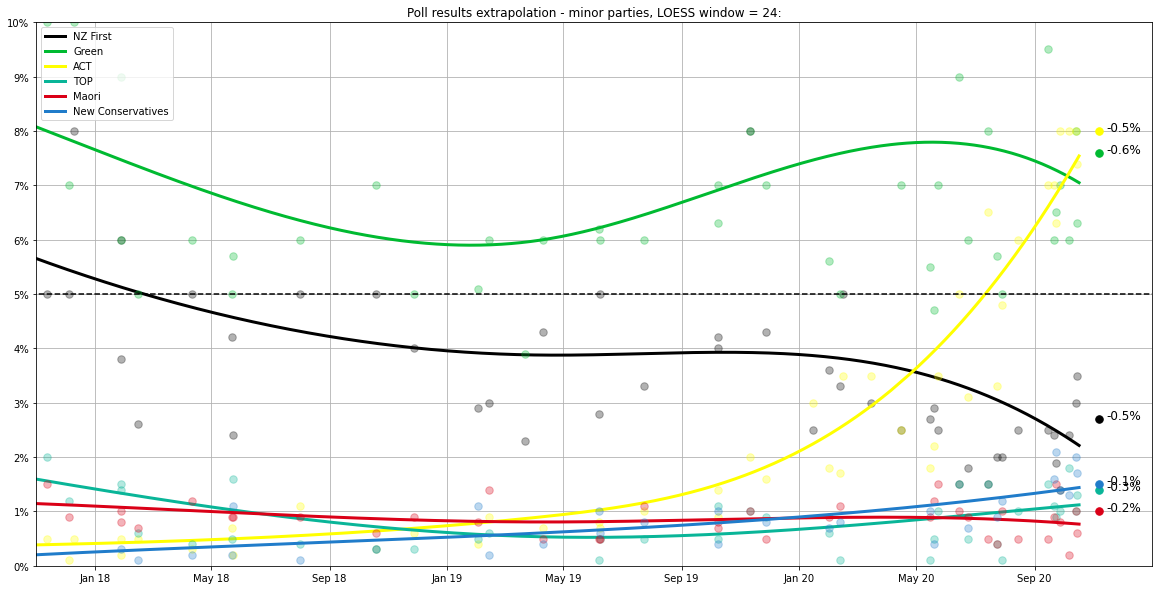

In [7]:
# MINOR PARTIES
yticks_minor = np.arange(0, 11, 1)
yticks_minor_format = [str(i)+'%' for i in yticks_minor]

plt.figure(figsize=(20,10))

for index, row in df_extrap.iterrows():
    
    party = row['name_short']
    
    if party in ['NAT', 'LAB']:
        continue
    
    plt.plot(df_polls['Date'], df_polls[party],
             color=row['colour'], linestyle='None', marker='.', markersize=15, alpha=0.3)
    
    x = row[7:7+n].index
    y = row[7:7+n].values
    
    epoch = min(df_polls['Date'][df_polls[party].notnull()])
    
    epoch_float = datetime.timestamp(datetime.combine(epoch, datetime.min.time()))
    
    xx = np.linspace(min(x), (election_day - epoch).total_seconds(), 1000)

    p = interpolate.splrep(x, y)
    yy = interpolate.splev(xx, p)
    
    xx_date = np.array([datetime.fromtimestamp(i+epoch_float) for i in xx])

    plt.plot(xx_date, yy, linestyle='-', color=row['colour'], linewidth=3, label=row['name_long'])

    plt.annotate(f'{row["error"]:.1f}%', (election_day+timedelta(days=28), row['actual_percent']), size=12)
    
    plt.plot(election_day+timedelta(days=21), row['actual_percent'], color=row['colour'], linestyle='None', marker='.', markersize=15)
         
plt.plot(xx, np.full(len(xx), 5.), 'k--', linewidth=1.5)
plt.grid(True)
plt.xlim(datetime(2017, 11, 1), datetime(2021, 1, 1))
plt.xticks(xticks, xticks_format)
plt.ylim(min(yticks_minor), max(yticks_minor))
plt.yticks(yticks_minor, yticks_minor_format)
plt.legend(loc=2)
plt.title(f'Poll results extrapolation - minor parties, LOESS window = {window}:');
# plt.savefig(f'{today_str}_poll_minor_parties_lowess_{window}.jpg', dpi=150, format='jpg', bbox_inches='tight');